In [913]:
import os
import re
import sys
import glob
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from invisible_cities.database  import load_db
from invisible_cities.io.dst_io import load_dst
from invisible_cities.io.dst_io import df_writer

In [914]:
# Rewrite to get values from the file
def get_x_y_z(filename):
   parts = pd.read_hdf(filename, 'MC/particles')

   parts[['event_id', 'particle_id', 'particle_name', 'primary', 'initial_x', 'initial_y', 'initial_z']].head(10)

get_x = lambda filename: get_x_y_z(filename)[0]
get_z = lambda filename: get_x_y_z(filename)[2]

In [915]:
# Load in the files
lt_dir = os.path.expandvars("../files/S1/")
# lt_dir = os.path.expandvars("../config/")
lt_filenames = glob.glob(os.path.join(lt_dir, "*.h5"))
lt_filenames = sorted(lt_filenames)
print(lt_filenames)

# Configure the detector database
detector_db = "new"
datapmt = load_db.DataPMT(detector_db, 0)
xpmt, ypmt = datapmt["X"].values, datapmt["Y"].values
sensorids  = datapmt["SensorID"].values

['../files/S1/NEW_S1_LT_11.next.h5', '../files/S1/NEW_S1_LT_12.next.h5', '../files/S1/NEW_S1_LT_20.next.h5', '../files/S1/NEW_S1_LT_24.next.h5', '../files/S1/NEW_S1_LT_30.next.h5', '../files/S1/NEW_S1_LT_39.next.h5', '../files/S1/NEW_S1_LT_40.next.h5', '../files/S1/NEW_S1_LT_8.next.h5', '../files/S1/NEW_S1_LT_9.next.h5']


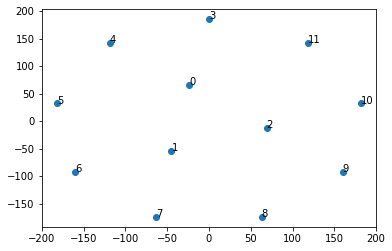

In [916]:
plt.scatter(xpmt, ypmt)
for x, y, sid  in zip(xpmt, ypmt, sensorids):
    plt.annotate(sid, (x, y))

In [917]:
filename = lt_filenames[0]
print(filename)
parts = pd.read_hdf(filename, 'MC/particles')
parts = parts[['event_id', 'initial_x', 'initial_y', 'initial_z']]


../files/S1/NEW_S1_LT_11.next.h5


In [918]:
# Get the metadata from the files
configuration = pd.read_hdf(filename, "MC/configuration").set_index("param_key")
num_events = int(configuration.loc["num_events"][0])
nphotons   = int(configuration.loc["/Generator/ScintGenerator/nphotons"][0])

sns_response  = pd.read_hdf(filename, "MC/sns_response")
pmt_response  = sns_response[np.isin(sns_response["sensor_id"].values, datapmt["SensorID"].values)]

pd.set_option('display.max_rows', None)
display(pmt_response.head(10))

,event_id,sensor_id,time_bin,charge
282,1100,8,0,1072
283,1100,6,0,1130
284,1100,6,1,1
285,1100,11,0,932
286,1100,11,1,1
287,1100,3,0,945
288,1100,4,0,1003
289,1100,4,1,1
290,1100,7,0,1063
291,1100,1,0,1654


In [919]:
# protection time bins
pmt_response = pmt_response.groupby(["sensor_id", "event_id"])["charge"].sum().to_frame().reset_index()
display(pmt_response.head(11))

,sensor_id,event_id,charge
0,0,1100,1451
1,0,1101,1199
2,0,1102,669
3,0,1103,1073
4,0,1104,1803
5,0,1105,1138
6,0,1106,697
7,0,1107,894
8,0,1108,818
9,0,1109,1413


In [920]:
# Merge the dataframes to add the x, y, z positions
pmt_response = pmt_response.merge(parts, on="event_id", how = 'inner')
display(pmt_response.head(10))

,sensor_id,event_id,charge,initial_x,initial_y,initial_z
0,0,1100,1451,-49.834881,-61.838348,416.637848
1,1,1100,1656,-49.834881,-61.838348,416.637848
2,2,1100,1402,-49.834881,-61.838348,416.637848
3,3,1100,945,-49.834881,-61.838348,416.637848
4,4,1100,1004,-49.834881,-61.838348,416.637848
5,5,1100,1086,-49.834881,-61.838348,416.637848
6,6,1100,1131,-49.834881,-61.838348,416.637848
7,7,1100,1063,-49.834881,-61.838348,416.637848
8,8,1100,1072,-49.834881,-61.838348,416.637848
9,9,1100,1005,-49.834881,-61.838348,416.637848


In [921]:
# Set the Binning
xmin=-200
xmax=200
xbw=50

zmin=0
zmax=700
zbw=100

xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = xbins
zbins = np.arange(zmin, zmax+zbw, zbw)

xbins_centre = np.arange(xmin+xbw/2, xmax+xbw/2, xbw)
ybins_centre = xbins_centre
zbins_centre = np.arange(zmin+zbw/2, zmax+zbw/2, zbw)

print(xbins)
print(xbins_centre)



[-200 -150 -100  -50    0   50  100  150  200]
[-175. -125.  -75.  -25.   25.   75.  125.  175.]


In [922]:
# Now bin the x, y, z positions
pmt_response['x'] = pd.cut(x=pmt_response['initial_x'], bins=xbins,labels=xbins_centre, include_lowest=True)
pmt_response['y'] = pd.cut(x=pmt_response['initial_y'], bins=ybins,labels=ybins_centre, include_lowest=True)
pmt_response['z'] = pd.cut(x=pmt_response['initial_z'], bins=zbins,labels=zbins_centre, include_lowest=True)

 # remove the initial x,y,z since we are done with them
pmt_response = pmt_response.drop(columns=['initial_x', 'initial_y', 'initial_z'])

In [923]:
# Normalise the charge in each PMT by the total number of photons simulated
pmt_response['charge'] = pmt_response['charge']/nphotons

LT = pmt_response

# LT  = pd.pivot_table(pmt_response , values="charge", columns="sensor_id", index=["x", "y", "z"])

display(LT.head(11))

,sensor_id,event_id,charge,x,y,z
0,0,1100,0.001451,-25.0,-75.0,450.0
1,1,1100,0.001656,-25.0,-75.0,450.0
2,2,1100,0.001402,-25.0,-75.0,450.0
3,3,1100,0.000945,-25.0,-75.0,450.0
4,4,1100,0.001004,-25.0,-75.0,450.0
5,5,1100,0.001086,-25.0,-75.0,450.0
6,6,1100,0.001131,-25.0,-75.0,450.0
7,7,1100,0.001063,-25.0,-75.0,450.0
8,8,1100,0.001072,-25.0,-75.0,450.0
9,9,1100,0.001005,-25.0,-75.0,450.0


In [924]:
# # to df
# LT = LT.to_frame().reset_index()
# LT["x"] = x; 
# LT["y"] = y; 
# LT["z"] = z;
# err = err.to_frame().reset_index()
# err["x"] = x; 
# err["y"] = y; 
# err["z"] = z;

# LT  = pd.pivot_table(LT , values="charge", columns="sensor_id", index=["x", "y", "z"])
# err = pd.pivot_table(err, values="charge", columns="sensor_id", index=["x", "y", "z"])
# LT .columns = LT .columns.rename("")
# err.columns = err.columns.rename("")


In [925]:
# display(LT.head(11))
# LT.info()

In [926]:
LT  = pd.DataFrame()
ERR = pd.DataFrame()

for i, filename in enumerate(lt_filenames, 1):
    sys.stdout.write(f"Processing file {i}/{len(lt_filenames)} \r")
    sys.stdout.flush()
    
    # x, y, z = get_x_y_z(filename)
    
    configuration = pd.read_hdf(filename, "MC/configuration").set_index("param_key")
    num_events = int(configuration.loc["num_events"][0])
    nphotons   = int(configuration.loc["/Generator/ScintGenerator/nphotons"][0])

    sns_response  = pd.read_hdf(filename, "MC/sns_response")
    pmt_response  = sns_response[np.isin(sns_response["sensor_id"].values, datapmt["SensorID"].values)]
    
    # protection time bins
    pmt_response = pmt_response.groupby(["sensor_id", "event_id"])["charge"].sum().to_frame().reset_index()

    # Load in the MC Particles
    parts = pd.read_hdf(filename, 'MC/particles')
    parts = parts[['event_id', 'initial_x', 'initial_y', 'initial_z']]

    # Merge the dataframes
    pmt_response = pmt_response.merge(parts, on="event_id", how = 'inner')

    # Now bin the x, y, z positions
    pmt_response['x'] = pd.cut(x=pmt_response['initial_x'], bins=xbins,labels=xbins_centre, include_lowest=True)
    pmt_response['y'] = pd.cut(x=pmt_response['initial_y'], bins=ybins,labels=ybins_centre, include_lowest=True)
    pmt_response['z'] = pd.cut(x=pmt_response['initial_z'], bins=zbins,labels=zbins_centre, include_lowest=True)

    # remove the initial x,y,z since we are done with them
    pmt_response = pmt_response.drop(columns=['initial_x', 'initial_y', 'initial_z'])

    # Normalise the charge in each PMT by the total number of photons simulated
    pmt_response['charge'] = pmt_response['charge']/nphotons
    
    # mean = pmt_response.groupby("sensor_id")["charge"].mean()
    # std  = pmt_response.groupby("sensor_id")["charge"].std()

    # lt  = mean/nphotons 
    # err = std/mean*100
    
    # to df
    # lt = lt.to_frame().reset_index()
    # lt["x"] = x; lt["y"] = y; lt["z"] = z;
    # err = err.to_frame().reset_index()
    # err["x"] = x; err["y"] = y; err["z"] = z;

    # lt  = pd.pivot_table(pmt_response, values="charge", columns="sensor_id", index=["x", "y", "z"])
    # err = pd.pivot_table(err, values="charge", columns="sensor_id", index=["x", "y", "z"])
    
    LT  = pd.concat([LT , pmt_response])
    # ERR = pd.concat([ERR, err])



In [927]:
lt = LT.groupby(["sensor_id", "x", "y", "z"])["charge"].sum().to_frame().reset_index()
display(lt.head(10))

,sensor_id,x,y,z,charge
0,0,-175.0,-175.0,50.0,NaN
1,0,-175.0,-175.0,150.0,NaN
2,0,-175.0,-175.0,250.0,NaN
3,0,-175.0,-175.0,350.0,NaN
4,0,-175.0,-175.0,450.0,NaN
5,0,-175.0,-175.0,550.0,NaN
6,0,-175.0,-175.0,650.0,NaN
7,0,-175.0,-125.0,50.0,0.001736
8,0,-175.0,-125.0,150.0,0.000963
9,0,-175.0,-125.0,250.0,NaN


In [928]:
LT  = pd.pivot_table(lt, values="charge", columns="sensor_id", index=["x", "y", "z"])
display(LT.head(10))

sensor_id                  0         1         2         3         4   \
x      y      z                                                         
-175.0 -125.0 50.0   0.001736  0.001722  0.001722  0.001343  0.001378   
              150.0  0.000963  0.000981  0.000976  0.000725  0.000806   
              350.0  0.002776  0.002993  0.002798  0.001961  0.001999   
       -75.0  50.0   0.002119  0.002234  0.002101  0.001714  0.001891   
              150.0  0.002025  0.002077  0.002034  0.001537  0.001605   
              350.0  0.002699  0.002910  0.002665  0.001952  0.002204   
              250.0  0.003603  0.003604  0.003457  0.002753  0.002821   
              450.0  0.004526  0.005598  0.003861  0.002755  0.003285   
              550.0  0.001195  0.001808  0.001107  0.000685  0.000881   
       -25.0  50.0   0.002991  0.003007  0.003177  0.002654  0.002574   

sensor_id                  5         6         7         8         9   \
x      y      z                                                         
-175.0 -125.0 50.0   0.001384  0.001383  0.001298  0.001427  0.001362   
              150.0  0.000814  0.000783  0.000814  0.000771  0.000794   
              350.0  0.002284  0.002183  0.002365  0.002165  0.001961   
       -75.0  50.0   0.001820  0.001715  0.001821  0.001863  0.001731   
              150.0  0.001569  0.001501  0.001540  0.001590  0.001549   
              350.0  0.002266  0.002250  0.002223  0.002088  0.001895   
              250.0  0.002742  0.002671  0.002815  0.002668  0.002592   
              450.0  0.004400  0.004994  0.003821  0.002976  0.002617   
              550.0  0.001520  0.002466  0.001370  0.000816  0.000671   
       -25.0  50.0   0.002336  0.002361  0.002512  0.002525  0.002408   

sensor_id                  10        11  
x      y      z                          
-175.0 -125.0 50.0   0.001346  0.001328  
              150.0  0.000779  0.000724  
              350.0  0.001831  0.001837  
       -75.0  50.0   0.001542  0.001665  
              150.0  0.001549  0.001525  
              350.0  0.001894  0.001837  
              250.0  0.002621  0.002636  
              450.0  0.002437  0.002595  
              550.0  0.000636  0.000628  
       -25.0  50.0   0.002342  0.002396

In [929]:
LT.columns = LT.columns.rename("")
# ERR.columns = err.columns.rename("")

LT  = LT.reset_index()
display(lt.head(10))
err = ERR.reset_index()

,sensor_id,x,y,z,charge
0,0,-175.0,-175.0,50.0,NaN
1,0,-175.0,-175.0,150.0,NaN
2,0,-175.0,-175.0,250.0,NaN
3,0,-175.0,-175.0,350.0,NaN
4,0,-175.0,-175.0,450.0,NaN
5,0,-175.0,-175.0,550.0,NaN
6,0,-175.0,-175.0,650.0,NaN
7,0,-175.0,-125.0,50.0,0.001736
8,0,-175.0,-125.0,150.0,0.000963
9,0,-175.0,-125.0,250.0,NaN


In [936]:
pmt = "PmtR11410"
signal_type = "S1"

for sid in sensorids:
    LT = LT.rename({sid: pmt + f"_{sid}"}, axis=1)
LT[pmt + f"_total"] = LT.loc[:, LT.columns.difference(["x", "y", "z"])].sum(axis=1)

if signal_type == "S2":
    LT = LT.drop("z", axis=1)

display(LT.tail(100))

,x,y,z,PmtR11410_0,PmtR11410_1,PmtR11410_2,PmtR11410_3,PmtR11410_4,PmtR11410_5,PmtR11410_6,PmtR11410_7,PmtR11410_8,PmtR11410_9,PmtR11410_10,PmtR11410_11,PmtR11410_total
204,75.0,-125.0,350.0,0.002595,0.002859,0.002754,0.001879,0.001899,0.001914,0.001929,0.002025,0.001987,0.001954,0.001921,0.001903,0.051238
205,75.0,-125.0,250.0,0.003515,0.003533,0.003543,0.002564,0.002533,0.002617,0.002597,0.002530,0.002516,0.002517,0.002590,0.002729,0.067568
206,75.0,-125.0,450.0,0.005398,0.006385,0.006588,0.003571,0.003557,0.003833,0.004099,0.004557,0.005310,0.005167,0.004295,0.004022,0.113564
207,75.0,-125.0,550.0,0.004685,0.006162,0.006816,0.002934,0.002853,0.003083,0.003553,0.004993,0.007937,0.006484,0.004121,0.003311,0.113864
208,75.0,-75.0,150.0,0.004154,0.004000,0.004015,0.002866,0.003060,0.002871,0.002853,0.002813,0.002829,0.002853,0.002913,0.002837,0.076128
209,75.0,-75.0,350.0,0.005463,0.005535,0.005642,0.003740,0.003769,0.003725,0.003794,0.003917,0.004109,0.004014,0.004045,0.003831,0.103168
210,75.0,-75.0,250.0,0.004945,0.004910,0.004954,0.003320,0.003574,0.003537,0.003448,0.003403,0.003381,0.003458,0.003454,0.003497,0.091762
211,75.0,-75.0,450.0,0.008306,0.009251,0.010624,0.005391,0.005399,0.005273,0.005657,0.006605,0.007616,0.007651,0.006790,0.006033,0.169192
212,75.0,-25.0,50.0,0.000754,0.000760,0.000809,0.000552,0.000525,0.000596,0.000565,0.000529,0.000539,0.000516,0.000549,0.000560,0.014508
213,75.0,-25.0,150.0,0.004225,0.004177,0.004144,0.002965,0.002870,0.002919,0.002964,0.002946,0.002842,0.002854,0.002840,0.002823,0.077138


In [931]:
save = True
outfilename = f"NEW-MC_{signal_type}_LT.h5"

if save:
    with tb.open_file(outfilename, 'w') as h5out:
        df_writer(h5out, LT, "LT", "LightTable")

In [932]:
# create config
config = { "detector"   : "new"
         , "ACTIVE_rad" : str(227)
         , "EL_GAP"     : str(6.0)
         , "table_type" : "energy"
         , "signal_type": signal_type
         , "sensor"     : pmt
         , "pitch_x"    : str(10)
         , "pitch_y"    : str(10)}

config = pd.DataFrame({"parameter": config.keys(), "value": config.values()})
if save:
    with tb.open_file(outfilename, 'r+') as h5out:
        df_writer(h5out, config, "LT", "Config")

In [933]:
lt     = load_dst(outfilename, "LT", "LightTable")
config = load_dst(outfilename, "LT", "Config")

In [934]:
display(lt.head(10))
display(config)

,x,y,z,PmtR11410_0,PmtR11410_1,PmtR11410_2,PmtR11410_3,PmtR11410_4,PmtR11410_5,PmtR11410_6,PmtR11410_7,PmtR11410_8,PmtR11410_9,PmtR11410_10,PmtR11410_11,PmtR11410_total
0,-175.0,-125.0,50.0,0.001736,0.001722,0.001722,0.001343,0.001378,0.001384,0.001383,0.001298,0.001427,0.001362,0.001346,0.001328,0.017429
1,-175.0,-125.0,150.0,0.000963,0.000981,0.000976,0.000725,0.000806,0.000814,0.000783,0.000814,0.000771,0.000794,0.000779,0.000724,0.009930
2,-175.0,-125.0,350.0,0.002776,0.002993,0.002798,0.001961,0.001999,0.002284,0.002183,0.002365,0.002165,0.001961,0.001831,0.001837,0.027153
3,-175.0,-75.0,50.0,0.002119,0.002234,0.002101,0.001714,0.001891,0.001820,0.001715,0.001821,0.001863,0.001731,0.001542,0.001665,0.022216
4,-175.0,-75.0,150.0,0.002025,0.002077,0.002034,0.001537,0.001605,0.001569,0.001501,0.001540,0.001590,0.001549,0.001549,0.001525,0.020101
5,-175.0,-75.0,350.0,0.002699,0.002910,0.002665,0.001952,0.002204,0.002266,0.002250,0.002223,0.002088,0.001895,0.001894,0.001837,0.026883
6,-175.0,-75.0,250.0,0.003603,0.003604,0.003457,0.002753,0.002821,0.002742,0.002671,0.002815,0.002668,0.002592,0.002621,0.002636,0.034983
7,-175.0,-75.0,450.0,0.004526,0.005598,0.003861,0.002755,0.003285,0.004400,0.004994,0.003821,0.002976,0.002617,0.002437,0.002595,0.043865
8,-175.0,-75.0,550.0,0.001195,0.001808,0.001107,0.000685,0.000881,0.001520,0.002466,0.001370,0.000816,0.000671,0.000636,0.000628,0.013783
9,-175.0,-25.0,50.0,0.002991,0.003007,0.003177,0.002654,0.002574,0.002336,0.002361,0.002512,0.002525,0.002408,0.002342,0.002396,0.031283


,parameter,value
0,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
1,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
2,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
3,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
4,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
5,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
6,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
7,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"


KeyError: 'ACTIVE_rad'

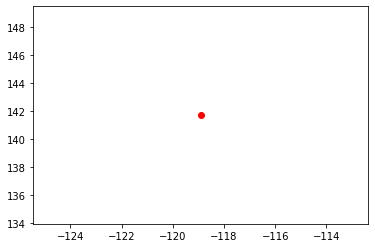

In [935]:
z = 170
sel = lt.z == z

sid = 4

plt.scatter(lt[sel].x, lt[sel].y, c=lt[sel][pmt + f"_{sid}"])
plt.scatter(datapmt[datapmt["SensorID"]==sid].X, datapmt[datapmt["SensorID"]==sid].Y, c="r")

r = float(config.set_index("parameter").loc["ACTIVE_rad"])
theta = np.linspace(0, 2*np.pi, 100)
x=r*np.cos(theta)
y=r*np.sin(theta)
plt.plot(x, y)

In [ ]:
sid = 3
plt.scatter(lt.x, lt.y, c=lt[pmt + f"_{sid}"])
plt.scatter(datapmt[datapmt["SensorID"]==sid].X, datapmt[datapmt["SensorID"]==sid].Y, c="r")

r = float(config.set_index("parameter").loc["ACTIVE_rad"])
theta = np.linspace(0, 2*np.pi, 100)
x=r*np.cos(theta)
y=r*np.sin(theta)
plt.plot(x, y)

In [ ]:
df_writer(h5out, conf_psf, "PSF", "Config", str_col_length = conf_psf.value.str.len().max())

In [ ]:
filename = "/mnt/lustre/scratch/home/usc/ie/gdl/NEXT100/LightTables/NEXT100_S2_LT.h5"

lt_ex  = load_dst(filename, "LT", "LightTable")
config = load_dst(filename, "LT", "Config")

In [ ]:
from invisible_cities.core.core_functions import binedges_from_bincenters
xbins = binedges_from_bincenters(np.unique(lt["x"]))
ybins = binedges_from_bincenters(np.unique(lt["y"]))

In [ ]:
sensor_id = 2

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[12, 5])
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
# light table
h, _, _ = np.histogram2d(lt["x"], lt["y"], weights=lt[sensor_id], bins=[xbins, ybins])
im0 = ax0.imshow(np.flip(h.T, axis=0), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]])
ax0.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
# fig.colorbar(im0, ax=ax0)

# err
h, _, _ = np.histogram2d(err["x"], err["y"], weights=err[sensor_id], bins=[xbins, ybins])
im1 = ax1.imshow(np.flip(h.T, axis=0), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]])
ax1.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
fig.colorbar(im1, ax=ax1)

In [ ]:
sensor_id = 2

fig, (ax0, ax1) = plt.subplots(1,2, figsize=[15, 5])
ax0.scatter(lt["x"], lt["y"], c=lt[sensor_id])
ax1.scatter(err["x"], err["y"], c=err[sensor_id])

ax0.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
ax1.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")

In [ ]:
old_table = os.path.expandvars("$LUSTRE/NEXT100/LightTables/NEXT100_S2_LT.h5")

from invisible_cities.io.dst_io import load_dst
old = load_dst(old_table, "LT", "LightTable")

In [ ]:
sensor_id = 31

fig, (ax0, ax1) = plt.subplots(1,2, figsize=[15, 5])

ax0.set_title("new")
ax0.scatter(lt["x"], lt["y"], c=lt[sensor_id])


ax1.set_title("old")
ax1.scatter(old["x"], old["y"], c=old[f"PmtR11410_{sensor_id}"], s=3)


plt.figure()
_, bins, _ = plt.hist(old[f"PmtR11410_{sensor_id}"], bins=100 , density=True, histtype="step", linewidth=2)
_, _   , _ = plt.hist(lt[sensor_id]                , bins=bins, density=True, alpha=0.5);